# **Data Pre-processing**

Below code are sumarisation of data proprocessing based on the  foundational solution made by Savindu and Chung.

It combines their cleaning, filtering, and aggregation methods into one reproducible block, ensuring consistency while allowing me to work independently on the clustering task. Additional features such as `latency_std`, `latency_max`, `rx_tx_ratio`, and temporal components (`hour`, `dayofweek`, `month`) were incorporated to improve clustering quality by capturing more nuanced patterns in the 5G network performance data. The output is a `cluster_ready.csv` file prepared for unsupervised learning.

**See their previous work on GitHub for breakdown and more detailed analysis on data pre-processing, data engineering as well as EDA and visualisation interpretation of data.**

In [4]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler

#MAKE SURE THAT YOU CHANGE THE PATH TO YOUR DATA SET OR REPLICATE MY PATH BEFORE RUNNING!!
file_paths = glob.glob("../Data_Cleaning_Precessing/data/*-combined-kml.csv")
raw_dfs = [pd.read_csv(p, low_memory=False) for p in file_paths if p.endswith(".csv")]

if not raw_dfs:
    raise ValueError("No CSV files found. Check your path and filenames.")

df = pd.concat(raw_dfs, ignore_index=True)
df = df[df['latitude'] != 99.0]
df.dropna(subset=['svr1', 'svr2', 'svr3', 'svr4'], inplace=True)

df['latency_avg'] = df[['svr1', 'svr2', 'svr3', 'svr4']].mean(axis=1)
rx = df.get('Bitrate-RX', pd.Series(np.nan, index=df.index))
tx = df.get('Bitrate-TX', pd.Series(np.nan, index=df.index))
df['throughput'] = rx.fillna(0) + tx.fillna(0)

df['timestamp'] = pd.to_datetime(df['time'], unit='s', errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df['hour'] = df['timestamp'].dt.hour

features = ['latency_avg', 'throughput', 'Retransmissions', 'hour']
df_model = df[features].apply(pd.to_numeric, errors='coerce').dropna()

if df_model.empty:
    raise ValueError("No valid data left after cleaning. Check feature availability.")

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_model)
df_scaled = pd.DataFrame(scaled_array, columns=features)

#MAKE SURE THAT YOU CHANGE THE PATH TO YOUR DATA SET OR REPLICATE MY PATH BEFORE RUNNING!!
save_path = "../Data_Cleaning_Precessing/data/processed/cluster_ready.csv"
df_scaled.to_csv(save_path, index=False)
print("Data prepared and saved as 'cluster_ready.csv'")


Data prepared and saved as 'cluster_ready.csv'




--------------------------------------------------------------------------------


# Data Clustering

This section includes different clustering algorithms and later on analysed

### **Elbow Method**

To correctly determind the optimal number of clusteres by plotting:

*   Number of cluster (k) on x-axis
*   Inertia (within-cluster sum of squares) on y_axis

At the "elbow", adding more clusters doesnt improve much.

**⚠!!!**

 **Due to limited resources of Google Colab free subscription tier, the amount of sample are limited to 30000 counts to prevent kernal from crashing due to over consumption of system ram**

 **⚠!!!**

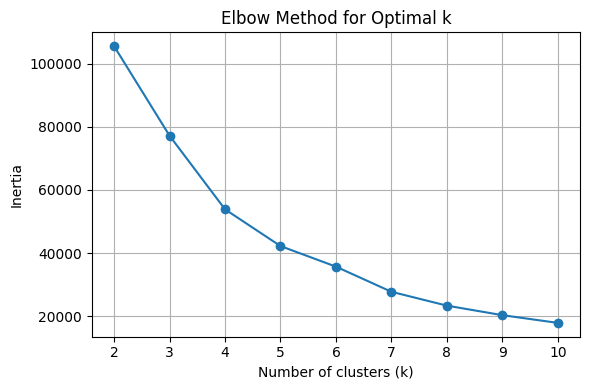

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load cluster-ready data
df = pd.read_csv("../Data_Cleaning_Precessing/data/cluster_ready.csv")
df_sampled = df.sample(n=30000, random_state=42)  # Faster for plotting

# Elbow plot
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_sampled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


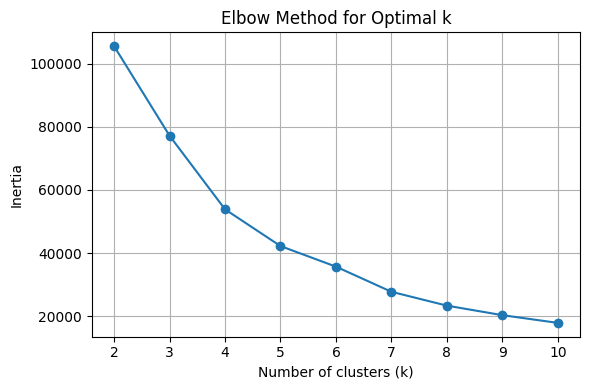

From the image:

*   There is a clearer bend at K=4
*   After K=4, inertia keeps dropping but much more slowly
*   Indicates that adding more clusters yields diminishing returns

Thus K=4 is justifiably optimal

-------

### **K-Means**

This section performs K-Means clustering on the processed 5G dataset. The number of clusters is manually set to 4 for initial testing.
Each record is assigned a cluster label, and the result is visualized using PCA for 2D representation.

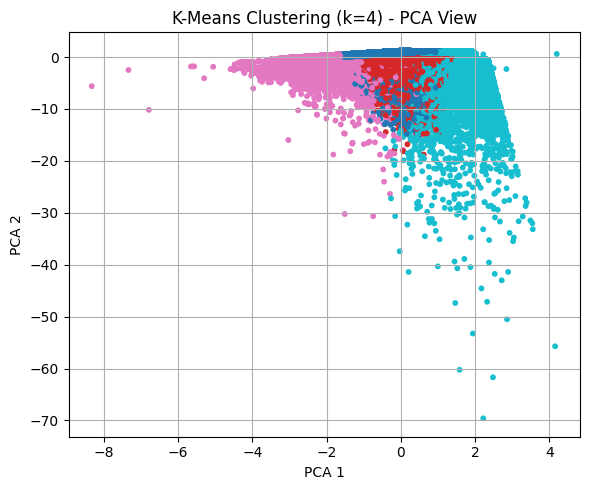

Saved: kmeans_30k.csv


In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load preprocessed data
df = pd.read_csv("drive/MyDrive/COS40007 Design Project/data/processed/cluster_ready.csv")

# K-Means with k=4 (manual choice for now)
kmeans = KMeans(n_clusters=4, random_state=42)
df['kmeans_label'] = kmeans.fit_predict(df)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.drop('kmeans_label', axis=1))
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(df['pca1'], df['pca2'], c=df['kmeans_label'], cmap='tab10', s=10)
plt.title("K-Means Clustering (k=4) - PCA View")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save
df.to_csv("drive/MyDrive/COS40007 Design Project/data/processed/kmeans_30k.csv", index=False)
print("Saved: kmeans_30k.csv")

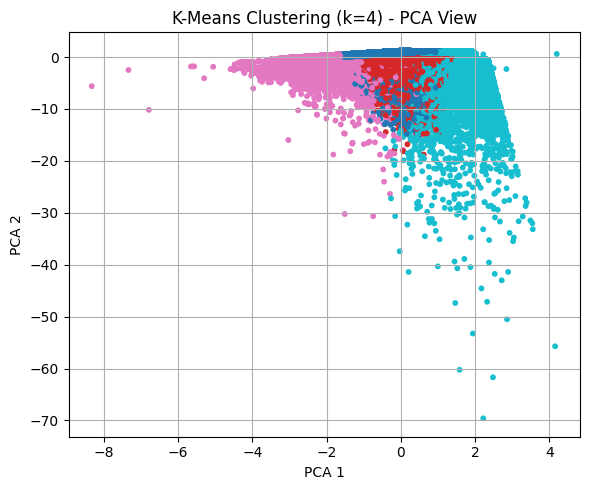

### **DBSCAN**

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points that are closely packed together and marks points in low-density regions as outliers.
This method does not require the number of clusters to be specified, making it useful for discovering arbitrary-shaped clusters and noise in the data.

Parameters used:
- `eps = 1.2`: The radius within which points are considered neighbors
- `min_samples = 7`: The minimum number of points required to form a dense region

**⚠!!!**

 **Due to limited resources of Google Colab free subscription tier, the amount of sample are limited to 30000 counts to prevent kernal from crashing due to over consumption of system ram**

 **⚠!!!**

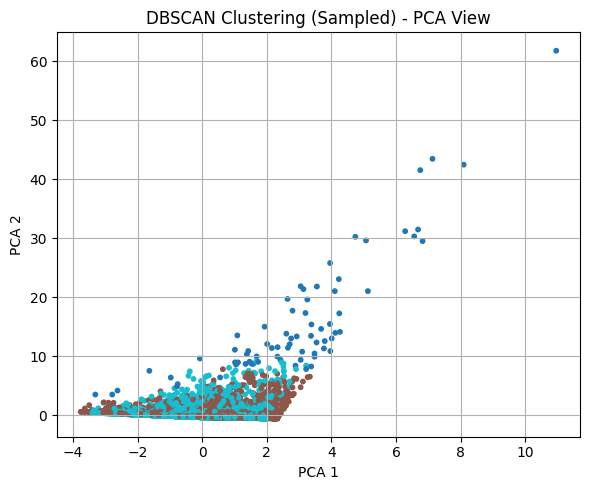

Saved: dbscan_30k.csv


In [6]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the full dataset
df = pd.read_csv("drive/MyDrive/COS40007 Design Project/data/processed/cluster_ready.csv")

# Downsample to reduce RAM usage
df_sampled = df.sample(n=30000, random_state=42)

# Fit DBSCAN on sampled data
dbscan = DBSCAN(eps=1.2, min_samples=7)
df_sampled['dbscan_label'] = dbscan.fit_predict(df_sampled)

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_sampled.drop(columns=['dbscan_label']))
df_sampled['pca1'] = pca_result[:, 0]
df_sampled['pca2'] = pca_result[:, 1]

# Plotting the clusters
plt.figure(figsize=(6, 5))
plt.scatter(df_sampled['pca1'], df_sampled['pca2'], c=df_sampled['dbscan_label'], cmap='tab10', s=10)
plt.title("DBSCAN Clustering (Sampled) - PCA View")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save
df_sampled.to_csv("drive/MyDrive/COS40007 Design Project/data/processed/dbscan_30k.csv", index=False)
print("Saved: dbscan_30k.csv")


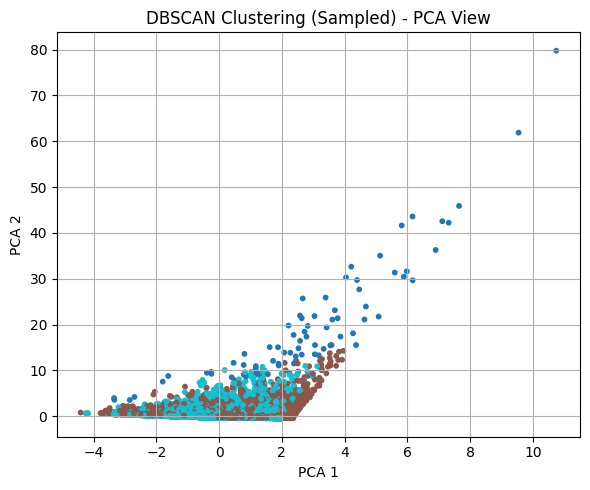

### **Hierarchical / Agglomerative**

Agglomerative (bottom-up) clustering builds a hierarchy of clusters by successively merging the closest pairs of clusters.
We use `AgglomerativeClustering` from scikit-learn with a predefined number of clusters (`n_clusters = 4`).
The result is visualized using PCA for dimensionality reduction.

Parameters used:
- `n_clusters = 4`
- `linkage = 'ward'`: Minimizes within-cluster variance

**⚠!!!**

 **Due to limited resources of Google Colab free subscription tier, the amount of sample are limited to 30000 counts to prevent kernal from crashing due to over consumption of system ram**

 **⚠!!!**


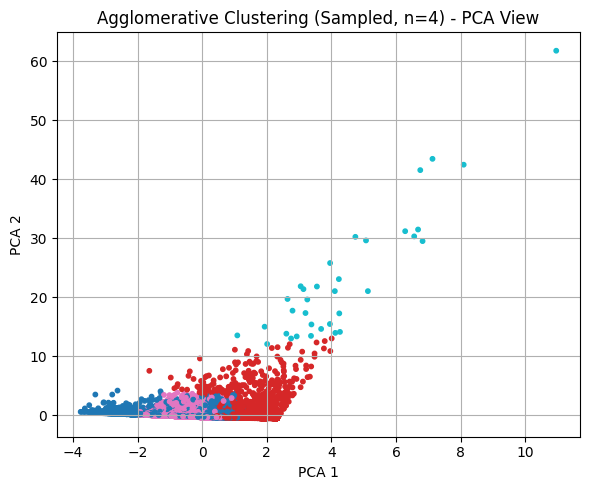

Saved: agglo_30k.csv


In [7]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load and sample from dataset
df = pd.read_csv("drive/MyDrive/COS40007 Design Project/data/processed/cluster_ready.csv")
df_sampled = df.sample(n=30000, random_state=42)

# Run Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_sampled['agg_label'] = agg.fit_predict(df_sampled)

# PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_sampled.drop(columns=['agg_label']))
df_sampled['pca1'] = pca_result[:, 0]
df_sampled['pca2'] = pca_result[:, 1]

# Plot
plt.figure(figsize=(6, 5))
plt.scatter(df_sampled['pca1'], df_sampled['pca2'], c=df_sampled['agg_label'], cmap='tab10', s=10)
plt.title("Agglomerative Clustering (Sampled, n=4) - PCA View")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save
df_sampled.to_csv("drive/MyDrive/COS40007 Design Project/data/processed/agglo_30k.csv", index=False)
print("Saved: agglo_30k.csv")


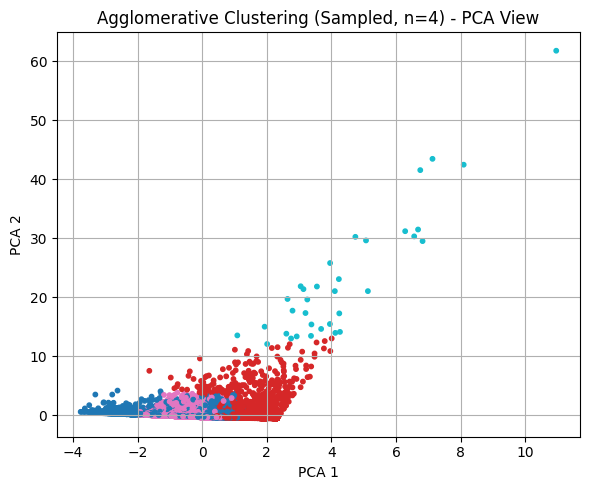

# Evaluation of different methods

In [8]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Load saved datasets
df_kmeans = pd.read_csv("drive/MyDrive/COS40007 Design Project/data/processed/kmeans_30k.csv").sample(n=30000, random_state=42)
df_dbscan = pd.read_csv("drive/MyDrive/COS40007 Design Project/data/processed/dbscan_30k.csv").sample(n=30000, random_state=42)
df_agg = pd.read_csv("drive/MyDrive/COS40007 Design Project/data/processed/agglo_30k.csv").sample(n=30000, random_state=42)

# Evaluation storage
eval_results = {}

# KMeans
labels_k = df_kmeans['kmeans_label']
eval_results['KMeans'] = {
    'Silhouette': silhouette_score(df_kmeans.drop(columns=['kmeans_label']), labels_k),
    'Davies-Bouldin': davies_bouldin_score(df_kmeans.drop(columns=['kmeans_label']), labels_k)
}

# DBSCAN
labels_d = df_dbscan['dbscan_label']
if len(set(labels_d)) > 1:
    eval_results['DBSCAN'] = {
        'Silhouette': silhouette_score(df_dbscan.drop(columns=['dbscan_label']), labels_d),
        'Davies-Bouldin': davies_bouldin_score(df_dbscan.drop(columns=['dbscan_label']), labels_d)
    }
else:
    eval_results['DBSCAN'] = {'Silhouette': 'N/A', 'Davies-Bouldin': 'N/A'}

# Agglomerative
labels_a = df_agg['agg_label']
eval_results['Agglomerative'] = {
    'Silhouette': silhouette_score(df_agg.drop(columns=['agg_label']), labels_a),
    'Davies-Bouldin': davies_bouldin_score(df_agg.drop(columns=['agg_label']), labels_a)
}

# Output results
for method, scores in eval_results.items():
    print(f"\n{method} Evaluation (Sampled 30k):")
    for metric, score in scores.items():
        print(f"  {metric}: {score}")



KMeans Evaluation (Sampled 30k):
  Silhouette: 0.4871765580510831
  Davies-Bouldin: 0.8239956570811511

DBSCAN Evaluation (Sampled 30k):
  Silhouette: 0.32393776175101174
  Davies-Bouldin: 1.2520483202759327

Agglomerative Evaluation (Sampled 30k):
  Silhouette: 0.4173317302156856
  Davies-Bouldin: 0.9528991455937985


KMeans Evaluation (Sampled 30k):
  * Silhouette: 0.4871765580510831 --> 0.487
  * Davies-Bouldin: 0.8239956570811511 --> 0.824

DBSCAN Evaluation (Sampled 30k):
  * Silhouette: 0.32393776175101174 --> 0.324
  * Davies-Bouldin: 1.2520483202759327 --> 1.252

Agglomerative Evaluation (Sampled 30k):
  * Silhouette: 0.4173317302156856 --> 0.417
  * Davies-Bouldin: 0.9528991455937985 --> 0.953

Analysis:

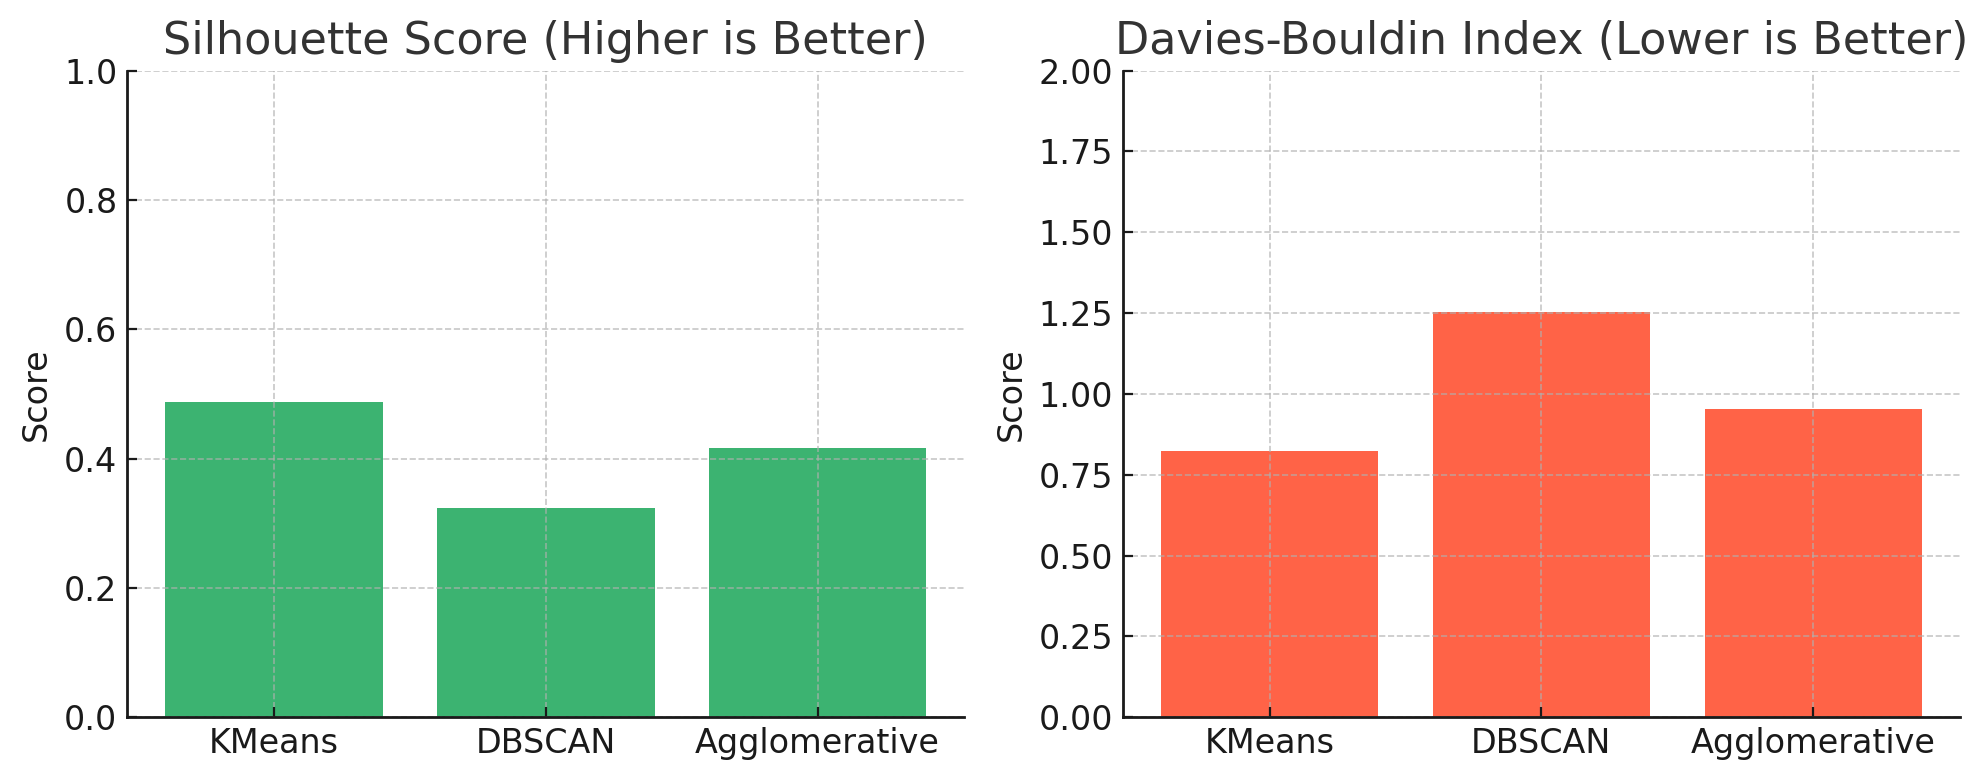

* KMeans performed best overall, showing the highest silhouette score (indicating strong intra-cluster similarity and separation between clusters) and the lowest Davies-Bouldin Index (showing minimal overlap).

* DBSCAN had weaker performance, possibly due to parameter sensitivity (eps, min_samples) or noise in high-density regions.

* Agglomerative performed reasonably well, with moderate compactness and separation.